# Libraries

In [1]:
from google.colab import drive
from scipy.stats import spearmanr

import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics
import torch

In [2]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Experiments/model-evaluation

Mounted at /content/drive
/content/drive/MyDrive/Experiments/model-evaluation


In [3]:
from model import Model

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluation Functions

In [5]:
from evaluation_functions import evaluate_analogies, evaluate_analogies_distance, evaluate_analogies_projected
from evaluation_functions import evaluate_similarity
from evaluation_functions import evaluate_word_sense, evaluate_word_sense_cos

# Get Models

## Our Models

In [6]:
versions = ["base", "v15", "v18", "v26"]
models = [torch.load("models/final_model_%s.torch" % v, map_location=device) for v in versions]
models = [model.embedding_input_dictionary() for model in models]

versions = [v + " (17M)" for v in versions]
with open('models/models.txt', 'r') as file:
    print(file.read())

base - Softplus for P(-) and P(+)
v15 - Dropout for input vectors
v18 - Only sigmoid for P(-), softplus+sigmoid for P(+)
v26 - Only negative loss, only sigmoid


## Standard Models
* **word2vec-google-news-300** : Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality'. [Source](https://arxiv.org/pdf/1301.3781.pdf)
* **glove-wiki-gigaword-300** : Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased. [Source](https://aclanthology.org/D14-1162.pdf)

[Details](https://github.com/RaRe-Technologies/gensim-data/blob/master/README.md)

In [7]:
w2v = api.load('word2vec-google-news-300')
w2v = {w2v.index_to_key[x] : w2v[x] for x in range(len(w2v))}

glove = api.load('glove-wiki-gigaword-300')
glove = {glove.index_to_key[x] : glove[x] for x in range(len(glove))}

versions.extend(["word2vec (100B)", "GloVe (6B)"])
models.extend([w2v, glove])
our_versions = versions[:4]
our_models = models[:4]

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 376.1/376.1MB downloaded


# Get Data

Used datasets mentioned in GloVe paper (link given above). \
Except:
* **MC-28**: Is a subset of RG-65.
* **SCWS**: Format not applicable, task is not comparable to others.


In [8]:
lines = open('data/google-analogy-test.txt', 'r').readlines()
analogies_test = [line.lower().strip().split() for line in lines[1:]] # First line invalid

print("Total analogies: %d" % (len(analogies_test)))

Total analogies: 19557


In [9]:
lines = open('data/wordsim_similarity_goldstandard.txt', 'r').readlines()
wordsim_similarity = [line.lower().strip().split() for line in lines]

print("Total pairs: %d" % (len(wordsim_similarity)))

Total pairs: 203


In [10]:
lines = open('data/wordsim_relatedness_goldstandard.txt', 'r').readlines()
wordsim_relatedness = [line.lower().strip().split() for line in lines]

print("Total pairs: %d" % (len(wordsim_relatedness)))

Total pairs: 252


In [11]:
lines = open('data/standford-rw-similarity.txt', 'r').readlines()
standford_rw = [line.lower().strip().split()[:3] for line in lines] # Take only first 3

print("Total pairs: %d" % (len(standford_rw)))

Total pairs: 2034


In [12]:
lines = open('data/rg65.txt', 'r').readlines()
rg65 = [line.lower().strip().split()[:3] for line in lines]

print("Total pairs: %d" % (len(rg65)))

Total pairs: 65


In [13]:
lines = open('data/simlex.txt', 'r').readlines()
simlex = [line.lower().strip().split()[:4] for line in lines[1:]]
simlex = [[x[0], x[1], x[3]] for x in simlex]

print("Total pairs: %d" % (len(simlex)))

Total pairs: 999


In [14]:
lines = open('data/gpt-dataset.txt', 'r').readlines()
gpt_dataset = [line.lower().strip().split(";") for line in lines]

print("Total examples: %d" % (len(gpt_dataset)))

Total examples: 100


# Evaluate Models

## Similarity

In [15]:
similarity_scores = dict()

In [16]:
for v, embeddings in enumerate(models):

  print("\n----- %s -----" % versions[v])

  score1 = evaluate_similarity(versions[v], "wordsim_similarity", embeddings, wordsim_similarity)
  print("Wordsim Similarity Score: %.4f" % score1)

  score2 = evaluate_similarity(versions[v], "wordsim_relatedness", embeddings, wordsim_relatedness)
  print("Wordsim Relatedness Score: %.4f" % score2)

  score3 = evaluate_similarity(versions[v], "wordsim_combined", embeddings, wordsim_similarity + wordsim_relatedness)
  print("Wordsim Combined Score: %.4f" % score3)

  score4 = evaluate_similarity(versions[v], "standford_rw", embeddings, standford_rw)
  print("Standford RW Score: %.4f" % score4)

  score5 = evaluate_similarity(versions[v], "rg65", embeddings, rg65)
  print("RG65 Score: %.4f" % score5)

  score6 = evaluate_similarity(versions[v], "simlex", embeddings, simlex)
  print("Simlex Score: %.4f" % score6)

  score7 = statistics.mean([score1, score2, score3, score4, score5, score6])
  print("Average Score: %.4f" % score7)

  similarity_scores[v] = [score1, score2, score3, score4, score5, score6, score7]


----- base (17M) -----
Wordsim Similarity Score: 0.6966
Wordsim Relatedness Score: 0.6228
Wordsim Combined Score: 0.6636
Standford RW Score: 0.2355
RG65 Score: 0.5733
Simlex Score: 0.2113
Average Score: 0.5005

----- v15 (17M) -----
Wordsim Similarity Score: 0.7068
Wordsim Relatedness Score: 0.6540
Wordsim Combined Score: 0.6839
Standford RW Score: 0.2564
RG65 Score: 0.6104
Simlex Score: 0.2224
Average Score: 0.5223

----- v18 (17M) -----
Wordsim Similarity Score: 0.6732
Wordsim Relatedness Score: 0.6107
Wordsim Combined Score: 0.6451
Standford RW Score: 0.2287
RG65 Score: 0.5880
Simlex Score: 0.1913
Average Score: 0.4895

----- v26 (17M) -----
Wordsim Similarity Score: 0.6948
Wordsim Relatedness Score: 0.6484
Wordsim Combined Score: 0.6765
Standford RW Score: 0.2114
RG65 Score: 0.5725
Simlex Score: 0.2228
Average Score: 0.5044

----- word2vec (100B) -----
Wordsim Similarity Score: 0.7771
Wordsim Relatedness Score: 0.6219
Wordsim Combined Score: 0.7004
Standford RW Score: 0.5342
RG65 

**Scores Reported in GloVe paper:**\
GloVe (6B):
* WordSim Total: 0.658
* RG: 0.778
* RW: 0.381

word2vec (100B):
* WordSim Total: 0.684
* RG: 0.754
* RW: 0.455

## Analogy

**Scores Reported in GloVe paper:**
GloVe (6B): 0.717

In [17]:
analogy_scores = dict()

In [18]:
for v, embeddings in enumerate(models):

  print("\n----- %s -----" % versions[v])

  correlation1 = evaluate_analogies(embeddings, analogies_test)
  print("\rCorrelation (Cosine Based Evaluation): %.4f" % correlation1)

  correlation2 = evaluate_analogies_distance(embeddings, analogies_test)
  print("\rCorrelation (Euclidian Based Evaluation): %.4f" % correlation2)

  analogy_scores[v] = [correlation1, correlation2]


----- base (17M) -----
Correlation (Cosine Based Evaluation): 0.1246
Correlation (Euclidian Based Evaluation): 0.0322

----- v15 (17M) -----
Correlation (Cosine Based Evaluation): 0.1480
Correlation (Euclidian Based Evaluation): 0.0562

----- v18 (17M) -----
Correlation (Cosine Based Evaluation): 0.0581
Correlation (Euclidian Based Evaluation): 0.0051

----- v26 (17M) -----
Correlation (Cosine Based Evaluation): 0.1123
Correlation (Euclidian Based Evaluation): 0.0226

----- word2vec (100B) -----
Correlation (Cosine Based Evaluation): 0.5373
Correlation (Euclidian Based Evaluation): 0.4790

----- GloVe (6B) -----
Correlation (Cosine Based Evaluation): 0.7157
Correlation (Euclidian Based Evaluation): 0.6968


## Word Sense Distinction

In [19]:
sense_scores = dict()

In [20]:
for v, embeddings in enumerate(models):

  print("\n----- %s -----" % versions[v])

  positives1, negatives1 = evaluate_word_sense(embeddings, embeddings, gpt_dataset)
  score1 = negatives1 - positives1
  print("\nProjection-Based\nPositive Samples: %.3f\nNegative Samples: %.3f" % (positives1, negatives1))
  print("Score: %.4f" % (score1))

  positives2, negatives2 = evaluate_word_sense_cos(embeddings, embeddings, gpt_dataset)
  score2 = negatives2 - positives2
  print("\nCosine-Based\nPositive Samples: %.3f\nNegative Samples: %.3f" % (positives2, negatives2))
  print("Score: %.4f" % (score2))

  sense_scores[v] = [score1, score2]


----- base (17M) -----

Projection-Based
Positive Samples: 0.053
Negative Samples: 0.070
Score: 0.0167

Cosine-Based
Positive Samples: 0.054
Negative Samples: 0.070
Score: 0.0158

----- v15 (17M) -----

Projection-Based
Positive Samples: 0.062
Negative Samples: 0.083
Score: 0.0209

Cosine-Based
Positive Samples: 0.064
Negative Samples: 0.083
Score: 0.0193

----- v18 (17M) -----

Projection-Based
Positive Samples: 0.043
Negative Samples: 0.064
Score: 0.0214

Cosine-Based
Positive Samples: 0.044
Negative Samples: 0.064
Score: 0.0204

----- v26 (17M) -----

Projection-Based
Positive Samples: 0.058
Negative Samples: 0.070
Score: 0.0122

Cosine-Based
Positive Samples: 0.059
Negative Samples: 0.071
Score: 0.0123

----- word2vec (100B) -----

Projection-Based
Positive Samples: 0.042
Negative Samples: 0.042
Score: -0.0003

Cosine-Based
Positive Samples: 0.051
Negative Samples: 0.042
Score: -0.0089

----- GloVe (6B) -----

Projection-Based
Positive Samples: 0.037
Negative Samples: 0.045
Score:

# Visualizations

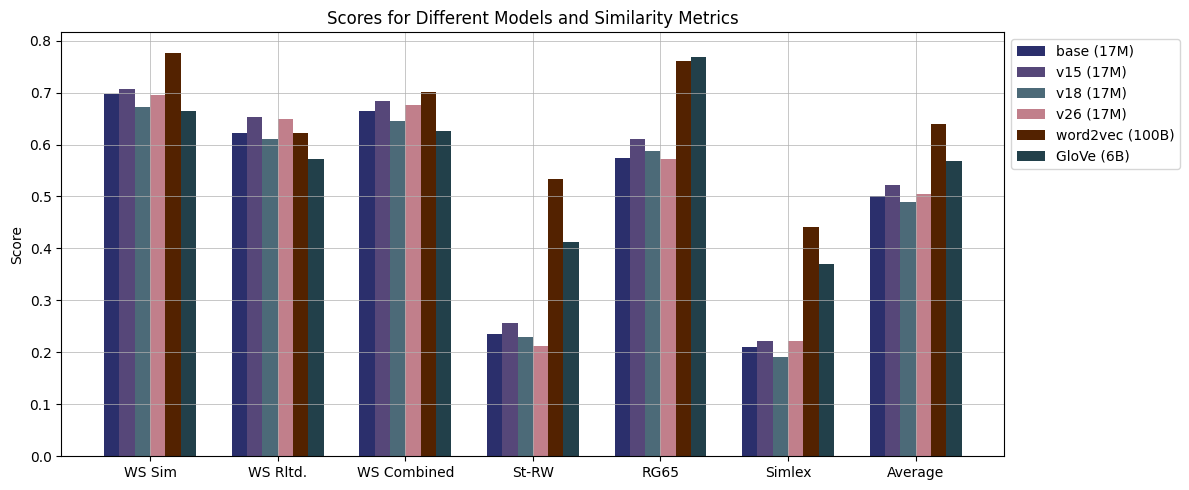

In [21]:
metrics = ['WS Sim', 'WS Rltd.', 'WS Combined', 'St-RW', 'RG65', 'Simlex', 'Average']
colors = ['#2B2F6C', '#564779', '#4C6A78', '#C17F8B', '#532200', '#22404A']

# Define the models and their respective scores
scores = list(similarity_scores.values())

bar_width = 0.12
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(12, 5))

for i, version in enumerate(versions):
    ax.bar(x + i * bar_width, [score for score in scores[i]], bar_width, label=version, color=colors[i])

ax.set_xticks(x + bar_width * (len(versions) - 1) / 2)
ax.set_xticklabels(metrics)

ax.set_ylabel('Score')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Scores for Different Models and Similarity Metrics')

plt.tight_layout()
plt.grid("both", linewidth=0.5)
plt.show()

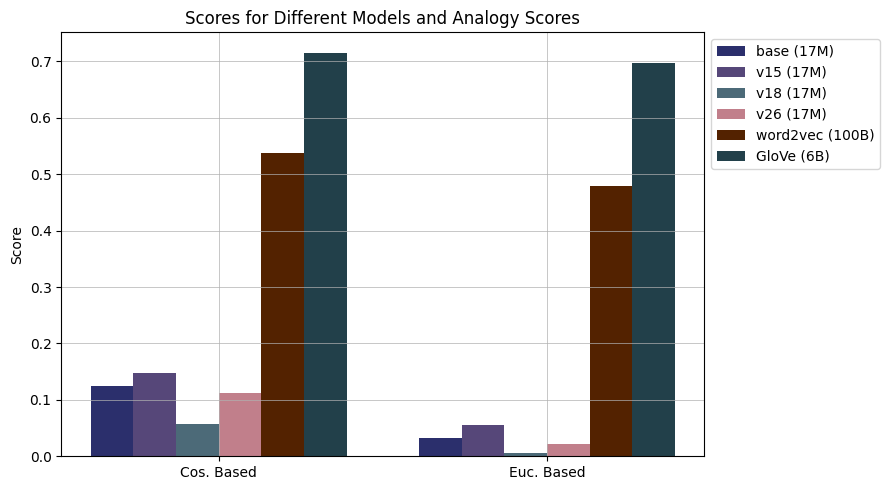

In [22]:
metrics = ['Cos. Based', 'Euc. Based']
colors = ['#2B2F6C', '#564779', '#4C6A78', '#C17F8B', '#532200', '#22404A']

# Define the models and their respective scores
scores = list(analogy_scores.values())

bar_width = 0.13
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(9, 5))

for i, version in enumerate(versions):
    ax.bar(x + i * bar_width, [score for score in scores[i]], bar_width, label=version, color=colors[i])

ax.set_xticks(x + bar_width * (len(versions) - 1) / 2)
ax.set_xticklabels(metrics)

ax.set_ylabel('Score')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Scores for Different Models and Analogy Scores')

plt.tight_layout()
plt.grid("both", linewidth=0.5)
plt.show()

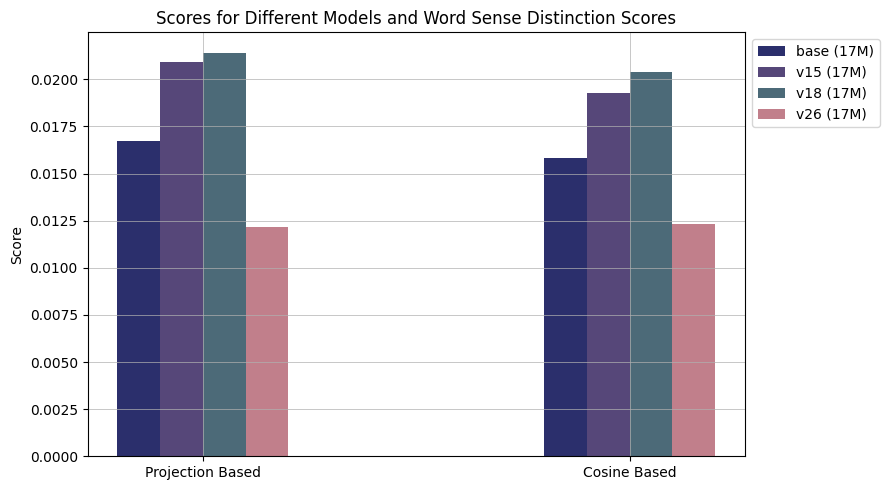

In [23]:
metrics = ["Projection Based", "Cosine Based"]
colors = ['#2B2F6C', '#564779', '#4C6A78', '#C17F8B', '#532200', '#22404A']

# Define the models and their respective scores
scores = list(sense_scores.values())

bar_width = 0.1
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(9, 5))

for i, version in enumerate(our_versions):
    ax.bar(x + i * bar_width, [score for score in scores[i]], bar_width, label=version, color=colors[i])

ax.set_xticks(x + bar_width * (len(our_versions) - 1) / 2)
ax.set_xticklabels(metrics)

ax.set_ylabel('Score')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Scores for Different Models and Word Sense Distinction Scores')

plt.tight_layout()
plt.grid("both", linewidth=0.5)
plt.show()

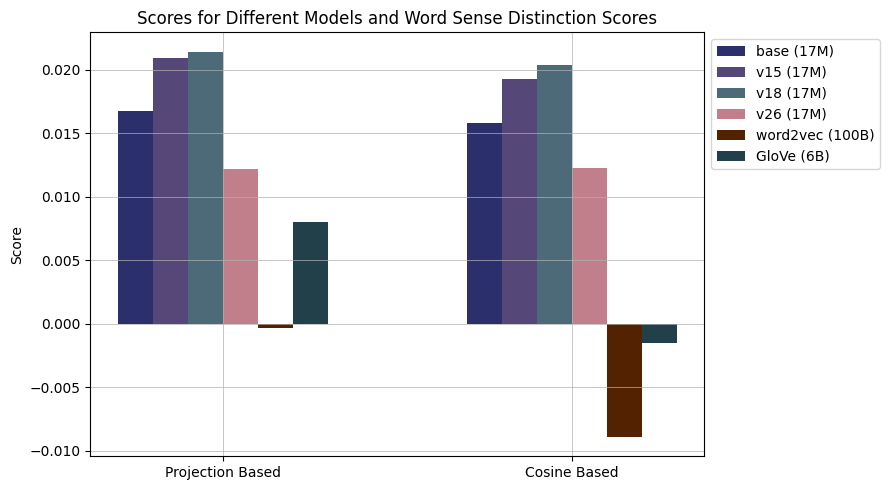

In [24]:
metrics = ["Projection Based", "Cosine Based"]
colors = ['#2B2F6C', '#564779', '#4C6A78', '#C17F8B', '#532200', '#22404A']

# Define the models and their respective scores
scores = list(sense_scores.values())

bar_width = 0.1
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(9, 5))

for i, version in enumerate(versions):
    ax.bar(x + i * bar_width, [score for score in scores[i]], bar_width, label=version, color=colors[i])

ax.set_xticks(x + bar_width * (len(versions) - 1) / 2)
ax.set_xticklabels(metrics)

ax.set_ylabel('Score')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Scores for Different Models and Word Sense Distinction Scores')

plt.tight_layout()
plt.grid("both", linewidth=0.5)
plt.show()

# DC

In [ ]:
from google.colab import runtime
runtime.unassign()